In [ ]:
pip install pymdptoolbox

  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25656 sha256=ff93a3bac9949f3129b981cee1c38d18434676b26c545273804c84cd2ec664a2
  Stored in directory: /root/.cache/pip/wheels/09/a8/27/a76d688633fa5d71984c288499c2170a8d06726135b8e216fd
Successfully built pymdptoolbox


In [ ]:
pip install mdptoolbox-hiive

  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-py3-none-any.whl size=35123 sha256=405f554d4b748b0e7d172fa4af931f4fb2e75e07185f2bcb7d0706f38f2baa68
  Stored in directory: /root/.cache/pip/wheels/7e/57/29/d73571a87eb4167889f15457e0ed88c71292f0da5590681248
Successfully built mdptoolbox-hiive


In [ ]:
pip install gym

In [ ]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example
import seaborn as sns; sns.set_theme()
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import gym
from gym import wrappers
from gym import Env, spaces, utils
from gym.envs.toy_text import frozen_lake, discrete
from gym.envs.registration import register


from six import StringIO, b

import logging



# Frozen Lake 

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
     "21x21": [
        "SFFFFFFFHHHFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFFHHFF",
        "FFFHFFFFFFFFHHFFFFFFF",
        "FFFFFFHFFFFFFFFFFHHFF",
        "FFFFFFHFFFFFFFFFFHHFF",
        "FFFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFHFFFFFFFHHFF",
        "FHFFFFHFFFFHHFFFFHHFF",
        "FFFFFFHFFFFFFFFFFHHFF",
        "FFFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFFHHHHHHHFF",
        "HHHHFHFFFFFFFFFFFHHFF",
        "FFFFFHFFFFFHHHFFFHHFF",
        "FFFFFFFFFFFFFFFFFHHFF",
        "FFHFFHFFFFFFFHFFFHHFF",
        "FFFFFHFFFFFFFFFFFHHFF",
        "FFFFFFFFFFFFHFFFFFFFF",
        "FHHFFFHFFFFFHFFFFFHFF",
        "FHHFHFHFFFFFFFFFFFFFF",
        "FHHFFFFFFFFFFFFFFFFFF",
        "FFFHHFFFFFHFFFFHHFHFG"
    ],
}

COLOR_MAP = {
        b'S': 'b',
        b'F': 'w',
        b'H': 'k',
        b'G': 'y'
        }

ACTION_MAP = {
            0: '⬅',
            1: '⬇',
            2: '➡',
            3: '⬆',
        }

In [ ]:
def plot_lake(env, value = None, policy= None, xoffset = 0.5, yoffset1 = 0.25, yoffset2 = 0.75,  p_size = 10, v_size = 5):
    fig, ax = plt.subplots()
    rows, cols = env.desc.shape
    if policy is not None : 
      policy = policy.reshape(env.nrow, env.ncol)
    if value is not None :
      value = value.reshape(env.nrow, env.ncol)

    for r in range(rows):
        for c in range(cols):
            x = c
            y = rows - r - 1

            char = env.desc[r, c]
            facecolor = COLOR_MAP[char]

            patch = plt.Rectangle((x, y), width=1, height=1, edgecolor='k', facecolor=facecolor, linewidth=0.2)
            
            if policy is not None : 
                p = ACTION_MAP[policy[r,c]]
                ax.text(x + xoffset, y+yoffset1, p , weight='bold', size=p_size, horizontalalignment='center', verticalalignment='center', color='k')
            if value is not None :
              v = value[r,c]
              ax.text(x + xoffset, y+yoffset2,  r'{0:.2f}'.format(v) , weight='bold', size=v_size, horizontalalignment='center', verticalalignment='center', color='k')

            ax.add_patch(patch)

    ax.axis('off')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    fig.tight_layout()


In [ ]:
#Modifications from OpenAI https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()



def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    metadata = {"render_modes": ["human", "ansi", "rgb_array"], "render_fps": 4}

    def __init__(self, desc=None, map_name="4x4", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()


        self.step_reward = -0.01
        self.hole_reward = -1.0
        self.goal_reward = 1.0
        self.step_prob = 0.75
        self.slip_prob = (1.0 - self.step_prob) / 2

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        #self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}
        P = {s: {a: [] for a in range(nA)} for s in range(nS)} 

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            reward = float(newletter == b"G")
            return newstate, reward, done


        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'G':
                        li.append((1.0, s, self.goal_reward, True))
                    else:
                        for b in [(a - 1) % 4, a, (a + 1) % 4]:
                          newrow, newcol = inc(row, col, b)
                          newstate = to_s(newrow, newcol)
                          newletter = desc[newrow, newcol]
                          done = bytes(newletter) in b'GH'
                          current_reward = float(newletter == b'G')
                          if newletter in b'FS':
                            current_reward = self.step_reward
                          elif newletter == b'H':
                            current_reward = self.hole_reward

                          if b == a:
                            li.append((self.step_prob, newstate, current_reward, done))
                          else:
                            li.append((self.slip_prob, newstate, current_reward, done))
        super().__init__(nS, nA, P, isd)


    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        return (int(s), r, d, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset()
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if not return_info:
            return int(self.s)
        else:
            return int(self.s), {"prob": 1}

    def render(self, mode="human"):
        desc = self.desc.tolist()
        if mode == "ansi":
            return self._render_text(desc)
        else:
            return self._render_gui(desc, mode)

    def _render_gui(self, desc, mode):
        import pygame
        from pygame.constants import SRCALPHA

        if self.window_surface is None:
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption("Frozen Lake")
            if mode == "human":
                self.window_surface = pygame.display.set_mode(self.window_size)
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.image.load(file_name)
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/cracked_hole.png")
            self.cracked_hole_img = pygame.image.load(file_name)
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.image.load(file_name)
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.image.load(file_name)
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.image.load(file_name)
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [pygame.image.load(f_name) for f_name in elfs]

        board = pygame.Surface(self.window_size, flags=SRCALPHA)
        cell_width = self.window_size[0] // self.ncol
        cell_height = self.window_size[1] // self.nrow
        smaller_cell_scale = 0.6
        small_cell_w = smaller_cell_scale * cell_width
        small_cell_h = smaller_cell_scale * cell_height

        # prepare images
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]
        elf_scale = min(
            small_cell_w / elf_img.get_width(),
            small_cell_h / elf_img.get_height(),
        )
        elf_dims = (
            elf_img.get_width() * elf_scale,
            elf_img.get_height() * elf_scale,
        )
        elf_img = pygame.transform.scale(elf_img, elf_dims)
        hole_img = pygame.transform.scale(self.hole_img, (cell_width, cell_height))
        cracked_hole_img = pygame.transform.scale(
            self.cracked_hole_img, (cell_width, cell_height)
        )
        ice_img = pygame.transform.scale(self.ice_img, (cell_width, cell_height))
        goal_img = pygame.transform.scale(self.goal_img, (cell_width, cell_height))
        start_img = pygame.transform.scale(self.start_img, (small_cell_w, small_cell_h))

        for y in range(self.nrow):
            for x in range(self.ncol):
                rect = (x * cell_width, y * cell_height, cell_width, cell_height)
                if desc[y][x] == b"H":
                    self.window_surface.blit(hole_img, (rect[0], rect[1]))
                elif desc[y][x] == b"G":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    goal_rect = self._center_small_rect(rect, goal_img.get_size())
                    self.window_surface.blit(goal_img, goal_rect)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    stool_rect = self._center_small_rect(rect, start_img.get_size())
                    self.window_surface.blit(start_img, stool_rect)
                else:
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))

                pygame.draw.rect(board, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (
            bot_col * cell_width,
            bot_row * cell_height,
            cell_width,
            cell_height,
        )
        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(cracked_hole_img, (cell_rect[0], cell_rect[1]))
        else:
            elf_rect = self._center_small_rect(cell_rect, elf_img.get_size())
            self.window_surface.blit(elf_img, elf_rect)

        self.window_surface.blit(board, board.get_rect())
        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self, desc):
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window_surface is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Sawyer http://www.cyaneus.com/

In [ ]:
# https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
# https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# https://www.analyticsvidhya.com/blog/2018/09/reinforcement-learning-model-based-planning-dynamic-programming/ 

def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    scores = [
            run_episode(env, policy, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

## Value Iteration 

In [ ]:
# https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
# https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# https://www.analyticsvidhya.com/blog/2018/09/reinforcement-learning-model-based-planning-dynamic-programming/ 

def value_iteration(env, gamma = 0.9,  max_iters=1000, eps=0.001):
  delta_max = np.inf
  counter = 0

  v = np.zeros(env.nS)
  p = np.zeros(env.nS)

  st=time.time() 
  while (True) :
    prev_v = np.copy(v)
    v_delta = 0

    for s in range (env.nS):
      actions = {i: act for i, act in enumerate(env.P[s].keys())}
      q_sa = np.zeros(len(actions))

      for i, a in actions.items():
        q_value  = sum(p*(r + (1 - done)*  (gamma * prev_v [s_])) for p, s_, r, done in env.P[s][a])
        q_sa[i] = q_value
        
      idx = np.argmax(q_sa) 
      v[s] = q_sa[idx]
      p[s] = actions[idx]

      
    counter += 1
    delta_max = 0

    for k in range (env.nS):
      delta = abs(v[k] - prev_v [k])
      if delta > delta_max:
        delta_max = delta

    if  (counter > max_iters or delta_max <= eps) :
      print ('Value-iteration converged at iteration# %d.' %(counter))
      break

  ts = time.time()  - st
  return v, p, counter, ts 
  





In [ ]:
lake4 = FrozenLakeEnv(map_name='15x15')
v1, p1, iter, ts = value_iteration(lake4, gamma = 0.9,  max_iters=500, eps=0.0001)
score = evaluate_policy(env = lake4, policy= p1, gamma = 0.9,  n = 500)


Value-iteration converged at iteration# 48.


In [ ]:
gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
eps = [0.1, 0.001, 0.0001, 0.00001, 0.000001]

time_array = []
reward_array = []
iter_array = []

lake4 = FrozenLakeEnv(map_name='4x4')

for g in gamma:
  for e in eps: 
    v, p, iter, ts  = value_iteration(env=lake4, gamma = g, max_iters=500, eps=e)
    score = evaluate_policy(env = lake4, policy= p, gamma = g,  n = 500)

    time_array.append(ts)
    iter_array.append(iter)
    reward_array.append(score)



Value-iteration converged at iteration# 2.
Value-iteration converged at iteration# 4.
Value-iteration converged at iteration# 4.
Value-iteration converged at iteration# 5.
Value-iteration converged at iteration# 6.
Value-iteration converged at iteration# 2.
Value-iteration converged at iteration# 4.
Value-iteration converged at iteration# 5.
Value-iteration converged at iteration# 6.
Value-iteration converged at iteration# 7.
Value-iteration converged at iteration# 3.
Value-iteration converged at iteration# 5.
Value-iteration converged at iteration# 6.
Value-iteration converged at iteration# 8.
Value-iteration converged at iteration# 9.
Value-iteration converged at iteration# 4.
Value-iteration converged at iteration# 7.
Value-iteration converged at iteration# 9.
Value-iteration converged at iteration# 11.
Value-iteration converged at iteration# 15.
Value-iteration converged at iteration# 5.
Value-iteration converged at iteration# 9.
Value-iteration converged at iteration# 14.
Value-it

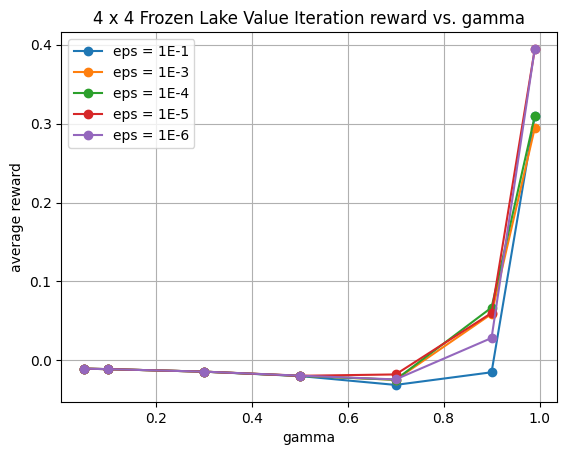

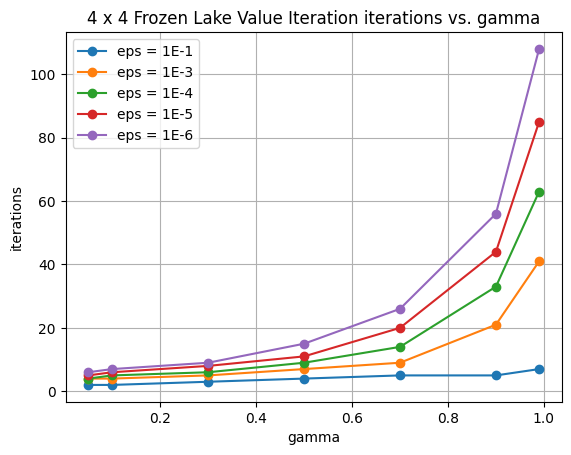

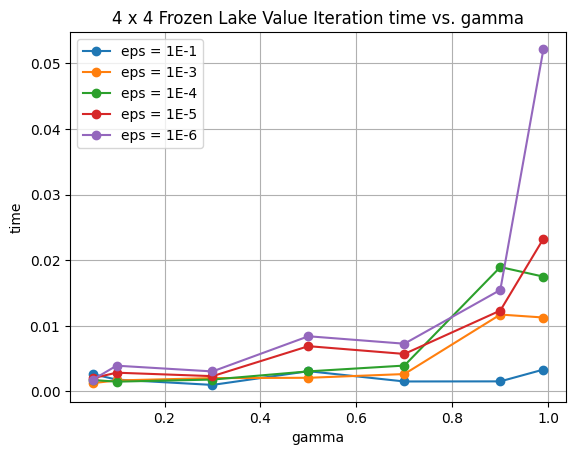

In [ ]:
iter_array = np.array(iter_array).reshape(7,5)
reward_array = np.array(reward_array).reshape(7,5)
time_array = np.array(time_array).reshape(7,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Value Iteration reward vs. gamma")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  iter_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Value Iteration iterations vs. gamma")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  time_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Value Iteration time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

Value-iteration converged at iteration# 33.


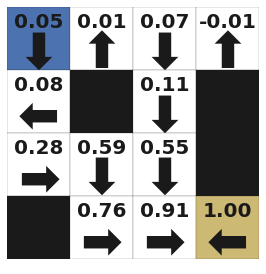

In [ ]:
lake = FrozenLakeEnv(map_name='4x4')
v1, p1, iter, ts = value_iteration(lake, gamma = 0.9,  max_iters=500, eps=0.0001)
score = evaluate_policy(env = lake, policy= p1, gamma = 0.9,  n = 500)
plot_lake(env = lake, value = v1, policy= p1,  xoffset = 0.5, yoffset1 = 0.25, yoffset2 = 0.75,  p_size = 50, v_size = 20)

Value-iteration converged at iteration# 56.


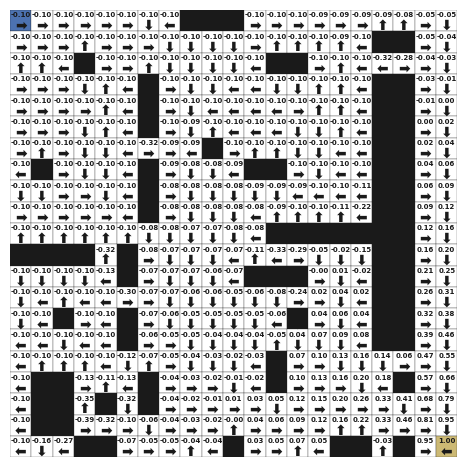

In [ ]:
plt.rcdefaults()
lake = FrozenLakeEnv(map_name='21x21')
v1, p1, iter, ts = value_iteration(lake, gamma = 0.9,  max_iters=500, eps=0.0001)
score = evaluate_policy(env = lake, policy= p1, gamma = 0.9,  n = 500)
plot_lake(env = lake, value = v1, policy= p1)

## Policy Iteration 

In [ ]:
# https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
# https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# https://www.analyticsvidhya.com/blog/2018/09/reinforcement-learning-model-based-planning-dynamic-programming/ 

def run_episode(env, policy, gamma = 1.0, render = False):
    """ Runs an episode and return the total reward """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0, n = 100):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def extract_policy(env, v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum(p*(r + (1 - done)*  (gamma * v [s_])) for p, s_, r, done in  env.P[s][a])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma=1.0, eps = 0.001):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.nS)
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] =sum(p*(r + (1 - done)*  (gamma * prev_v [s_])) for p, s_, r, done in env.P[s][policy_a])

        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
        delta_max = 0 

    return v





  


In [ ]:
def policy_iteration(env, gamma = 0.9,  max_iters=1000, eps=0.001):
  delta_max = np.inf
  p = np.random.choice(env.nA, size=(env.nS))

  st=time.time() 
  counter = 0 
  while (True) :
    v = compute_policy_v(env, p, gamma)
    new_policy = extract_policy(env, v, gamma)

    if (np.all(p == new_policy)):
      print ('Policy-Iteration converged at step %d.' %(counter))
      break

    p = new_policy
    counter +=1 

  ts = time.time()  - st
  return p, v, counter, ts 
  


In [ ]:
lake4 = FrozenLakeEnv(map_name='4x4')
env = lake4

optimal_policy, v , counter, ts  = policy_iteration(env, gamma = 0.9)
scores = evaluate_policy(env, optimal_policy, gamma = 0.9)
print('Average scores = ', np.mean(scores))

Policy-Iteration converged at step 2.
Average scores =  0.08032065060280427


In [ ]:
gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
eps = [0.1, 0.001, 0.0001, 0.00001, 0.000001]

time_array = []
reward_array = []
iter_array = []

lake4 = FrozenLakeEnv(map_name='4x4')

for g in gamma:
  for e in eps: 
    p, v, iter, ts  = policy_iteration(env=lake4, gamma = g, max_iters=500, eps=e)
    score = evaluate_policy(env = lake4, policy= p, gamma = g,  n = 500)

    time_array.append(ts)
    iter_array.append(iter)
    reward_array.append(score)

Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 2.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 4.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 3.
Policy-Iteration converged at step 4.
Policy-Itera

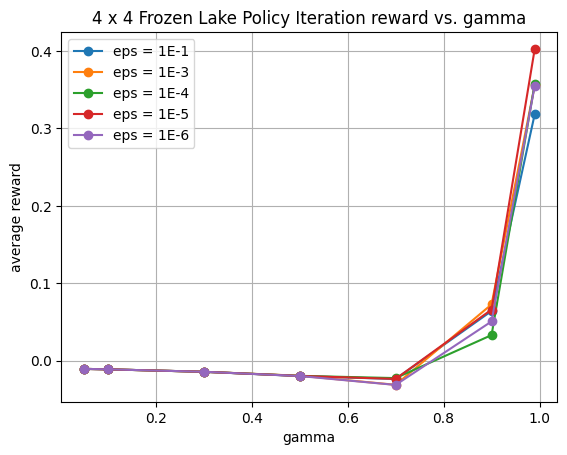

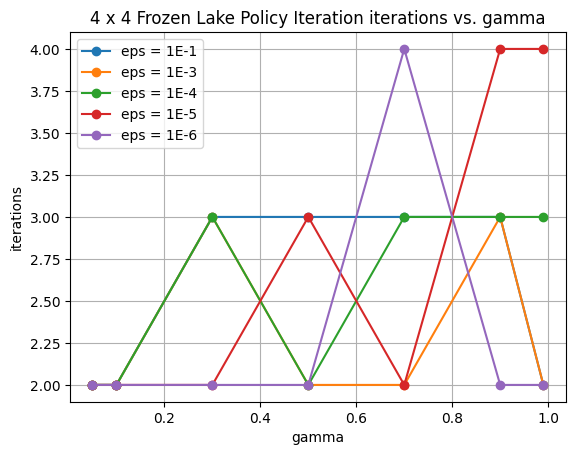

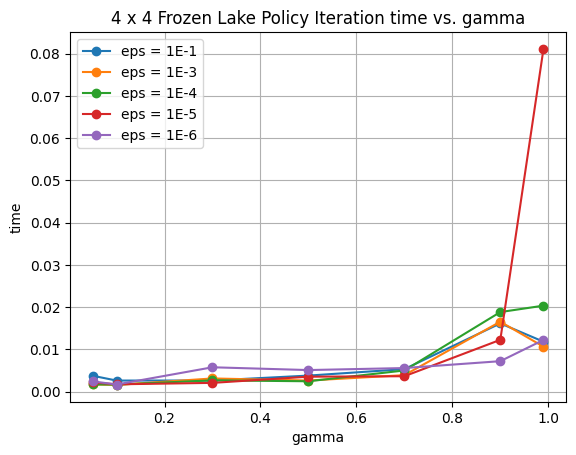

In [ ]:
iter_array = np.array(iter_array).reshape(7,5)
reward_array = np.array(reward_array).reshape(7,5)
time_array = np.array(time_array).reshape(7,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Policy Iteration reward vs. gamma")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  iter_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Policy Iteration iterations vs. gamma")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  time_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Policy Iteration time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

Policy-Iteration converged at step 3.


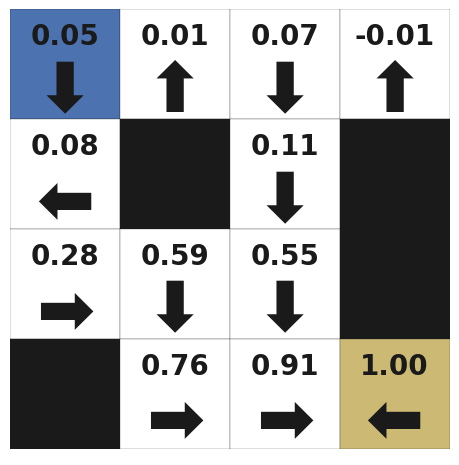

In [ ]:
lake = FrozenLakeEnv(map_name='4x4')
p1, v1, iter, ts = policy_iteration(lake, gamma = 0.9,  max_iters=500, eps=0.0001)
score = evaluate_policy(env = lake, policy= p1, gamma = 0.9,  n = 500)
plot_lake(env = lake, value = v1, policy= p1,  xoffset = 0.5, yoffset1 = 0.25, yoffset2 = 0.75,  p_size = 50, v_size = 20)

Policy-Iteration converged at step 10.


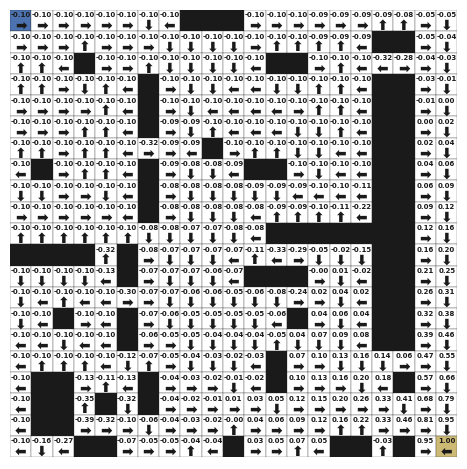

In [ ]:
lake = FrozenLakeEnv(map_name='21x21')
p1, v1, iter, ts = policy_iteration(lake, gamma = 0.9,  max_iters=500, eps=0.0001)
score = evaluate_policy(env = lake, policy= p1, gamma = 0.9,  n = 500)
plot_lake(env = lake, value = v1, policy= p1)

## Q-learning 

In [ ]:
def Qlearning(env, gamma = 0.9, eps = 0.0001, alps = 0.1):
  

  policy = {s: {a: [] for a in range(env.nA)} for s in range(env.nS)} 
  q_table = np.zeros((env.nS, env.nA ))

  for s in list(env.P.keys()):
    policy[s] = 0
    for a in list(range(env.action_space.n)):
      q_table[s][a] = 0.0 

  
  iteration = 1  
  st=time.time()  

  while (True):
    states = [env.reset()]
    delta_max = 0.0
    
    epsilon = eps(iteration)
    alpha = alps(iteration)

    for i_step in range(250): # 150, 100 
      state, reward, next_state, done, delta_q, q_table = step(env,q_table, gamma, epsilon, alpha)
      delta_max = max(delta_max, delta_q)
      states.append(next_state)

      if done:
        break

    for s in set(states) :
      action = choose_a(env, s, q_table, epsilon)
      policy[s] = action

    if (delta_max <0.0001 ):
       print ('Q - learning converged at step %d.' %(iteration))
       break
    elif (iteration> 5000):
      print('Q - learning did not converge')
      break 

    iteration += 1
  
  return policy, iteration, (time.time() - st)

def step(env, q_table, gamma, epsilon, alpha):
  s = env.s
  a = choose_a(env, s, q_table, epsilon)
  obs, reward, done , _ = env.step(a)
  q_next = (1 - done)  * np.max(get_q(env, obs, q_table))
  delta_q = alpha * (reward + gamma * q_next - q_table[s, a]) 
  q_table[s, a] += delta_q

  return s, reward, obs, done, abs(delta_q), q_table

def choose_a(env, state, q,  eps):
  these_q = get_q(env, state, q)
  idx = np.argmax(these_q)

  if eps > 0:
    weights = np.ones(len(these_q)) * eps / len(these_q)
    weights[idx] += 1.0 - eps
    action = np.random.choice(len(these_q), p=weights)
  else:
    action = idx

  return action

def get_q(env, s, q):
  return np.array([q[(s, a)] for a in list(range(env.action_space.n))])





In [ ]:
lake = FrozenLakeEnv(map_name='4x4')

Q - learning converged at step 1469.


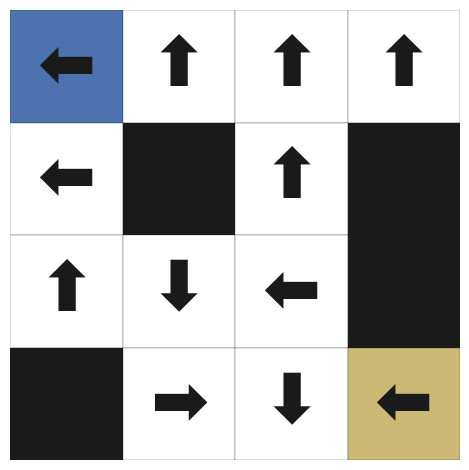

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.001, 0.001])
lake = FrozenLakeEnv(map_name='4x4')

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)
p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 50, v_size = 20)

Q - learning converged at step 1468.


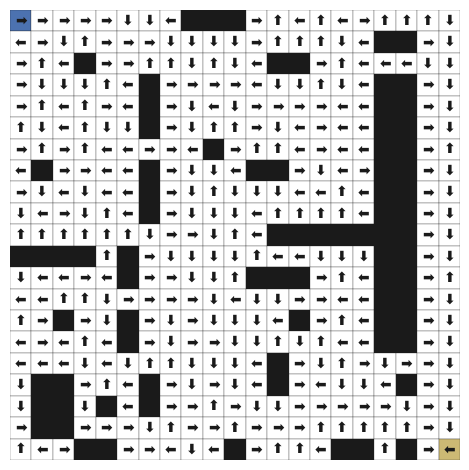

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.3, 0.3])
lake = FrozenLakeEnv(map_name='21x21')

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)

p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 10, v_size = 20)

### Alpha Decay 

Q - learning did not converge


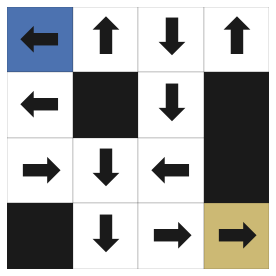

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.3, 0.3])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
lake = FrozenLakeEnv(map_name='4x4')

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)

p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 50, v_size = 20)


Q - learning did not converge


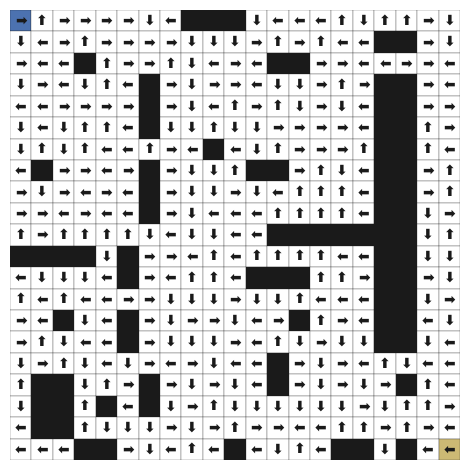

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.3, 0.3])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
lake = FrozenLakeEnv(map_name='21x21')

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)

p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 10, v_size = 20)

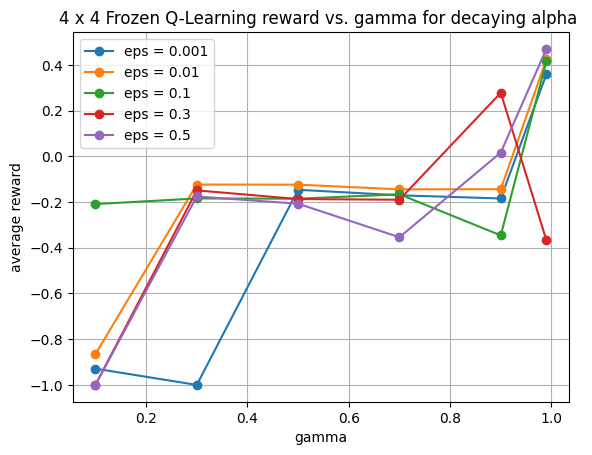

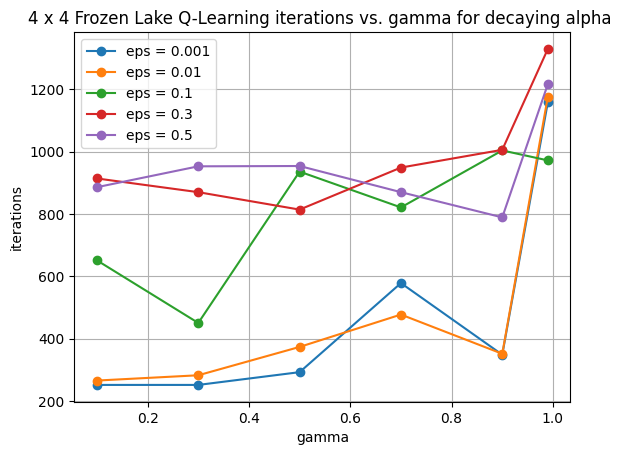

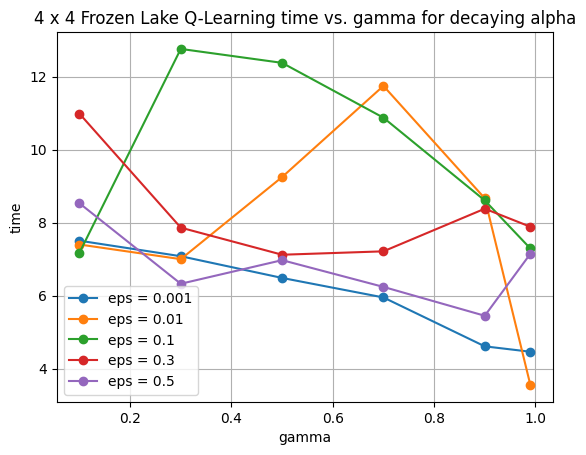

In [ ]:
iter_array = [251,265, 651, 914,886,251,282,450,870,953,292,373,936,814,954,578,477,821,949,870,348,351, 1004,1006,789,1159,1177,972,1330, 1217]
reward_array = [-0.9288000000000004, -0.8653000000000005, -0.20900000000000044, -1.0000000000000004, -1.0000000000000004, -1.0000000000000004, -0.12344000000000042, -0.1843000000000004, -0.14900000000000044, -0.17572000000000043, -0.1463600000000004, -0.1239600000000004, -0.18538000000000046, -0.18696000000000043, -0.20730000000000046, -0.17056000000000043, -0.14444000000000043, -0.16626000000000044, -0.18992000000000045, -0.35400000000000054, -0.18440000000000042, -0.1438000000000004, -0.3458400000000005, 0.27775999999999995, 0.01637999999999966, 0.35897999999999997, 0.42371999999999993, 0.41495999999999994, -0.3663000000000005, 0.46975999999999996]
time_array = [7.502241373062134, 7.398316383361816, 7.172124862670898, 10.983521461486816, 8.528178930282593, 7.077090740203857, 6.996649265289307, 12.756932973861694, 7.86029052734375, 6.322612524032593, 6.482276916503906, 9.246510744094849, 12.375102996826172, 7.117823362350464, 6.969328165054321, 5.947483062744141, 11.744083166122437, 10.87261700630188, 7.211008548736572, 6.236361980438232, 4.60811710357666, 8.664093255996704, 8.605371236801147, 8.378808975219727, 5.445732831954956, 4.460118055343628, 3.5509464740753174, 7.289113998413086, 7.884448528289795, 7.142764568328857]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

iter_array = np.array(iter_array).reshape(6,5)
reward_array = np.array(reward_array).reshape(6,5)
time_array = np.array(time_array).reshape(6,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "eps = 0.001",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "eps = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Q-Learning reward vs. gamma for decaying alpha ")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()


plt.plot(gamma,  iter_array[:,0], label = "eps = 0.001",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "eps = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Q-Learning iterations vs. gamma for decaying alpha ")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.plot(gamma,  time_array[:,0], label = "eps = 0.001",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "eps = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Q-Learning time vs. gamma for decaying alpha")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

### Epsilon Decay 

Q - learning converged at step 1732.


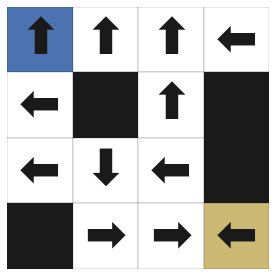

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.001, 0.001])

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)

p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 50, v_size = 20)


Q - learning converged at step 1367.


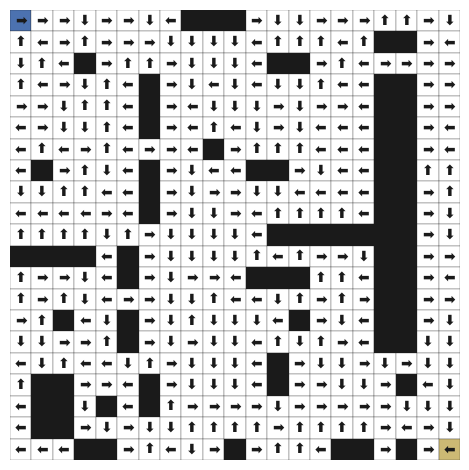

In [ ]:
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.3, 0.3])
lake = FrozenLakeEnv(map_name='21x21')

policy_001, iter_001, t001  = Qlearning(lake, gamma = 0.9, eps = eps, alps = alps)

p = np.zeros(lake.nS)

for k in  lake.P.keys():
  p[k] = policy_001[k]
  
plot_lake(env = lake, policy= p,  xoffset = 0.5, yoffset1 = 0.5, yoffset2 = 0.3,  p_size = 10, v_size = 20)

In [ ]:
gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha = [0.5, 0.3, 0.1, 0.01, 0.001]
eps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.2, 0.05])
alps = lambda timepoint: np.interp(x=timepoint, xp = [0,1500], fp = [0.3, 0.3])

time_array = []
reward_array = []
iter_array = []

lake4 = FrozenLakeEnv(map_name='4x4')


p, iter, ts  = Qlearning(lake, gamma = 0.1, eps = eps, alps = alps)
score = evaluate_policy(env = lake, policy= p, gamma = 0.9,  n = 500)

print( iter, ts, score)


Q - learning converged at step 512.
512 1.1404070854187012 -0.13703690811343835


In [ ]:
iter_array = [251,251, 261, 5000,5000,251,251,251,5000,5000,251,251,251,5000,5000,251,251,251,5000,5000,251,251, 347,5000,5000,251,251,289,5000,5000]
reward_array = [-1.1544400000000004, -0.43966000000000055, -0.30836000000000047, -1.0000000000000004, -1.0000000000000004, -1.0000000000000004, -0.5046400000000004, -0.17356000000000044, -0.18492000000000045, -1.0000000000000004, -0.020180000000000156, -1.0000000000000004, -0.16702000000000045, -0.13180000000000042, -0.8469600000000005, -0.4048000000000005, -0.8790600000000004, -0.23316000000000048, -0.31562000000000046, -0.1511200000000004, -1.36884, -0.8937600000000004, -0.14722000000000035, 0.04479999999999997, -0.22838000000000044, -0.3215200000000005, -0.3865200000000005, 0.37998, 0.4410199999999999, -0.33168000000000053]
time_array = [2.8932769298553467, 2.5304980278015137, 2.802903413772583, 86.4651403427124, 84.1437361240387, 2.2086126804351807, 2.435502290725708, 2.3076469898223877, 70.19563364982605, 76.23858284950256, 2.505790948867798, 2.5864310264587402, 2.1413321495056152, 62.95468997955322, 64.7500729560852, 2.215315818786621, 2.086498737335205, 2.5022716522216797, 59.87174415588379, 61.29504704475403, 2.315261125564575, 2.5721311569213867, 2.4743895530700684, 49.116052865982056, 55.36285376548767, 2.40238356590271, 2.47109317779541, 4.527114391326904, 44.59820294380188, 47.092592000961304]

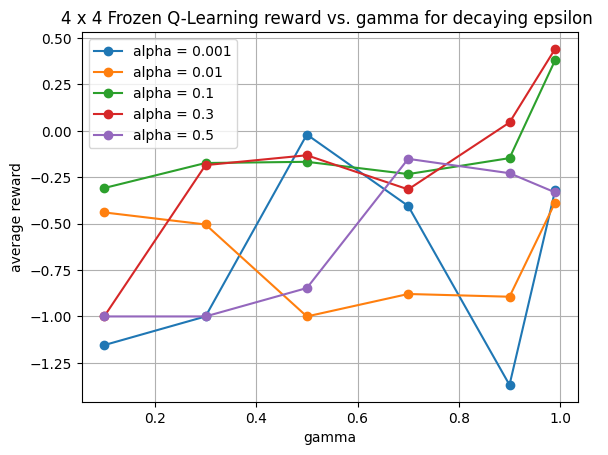

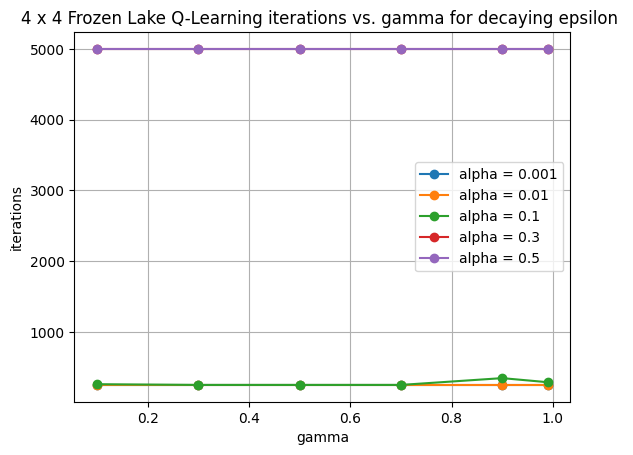

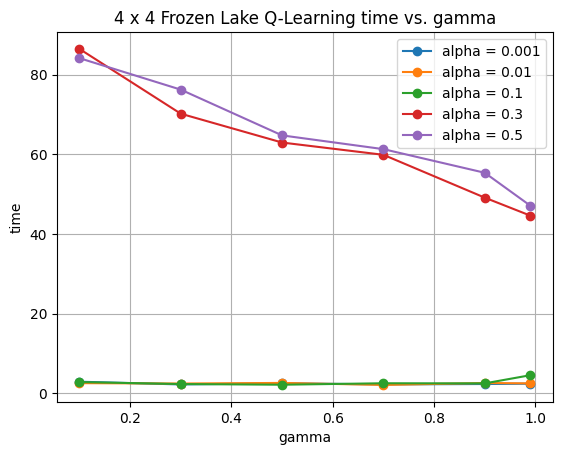

In [ ]:
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
alpha = [0.5, 0.3, 0.1, 0.01, 0.001]
iter_array = np.array(iter_array).reshape(6,5)
reward_array = np.array(reward_array).reshape(6,5)
time_array = np.array(time_array).reshape(6,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Q-Learning reward vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()


plt.plot(gamma,  iter_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Q-Learning iterations vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.plot(gamma,  time_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("4 x 4 Frozen Lake Q-Learning time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

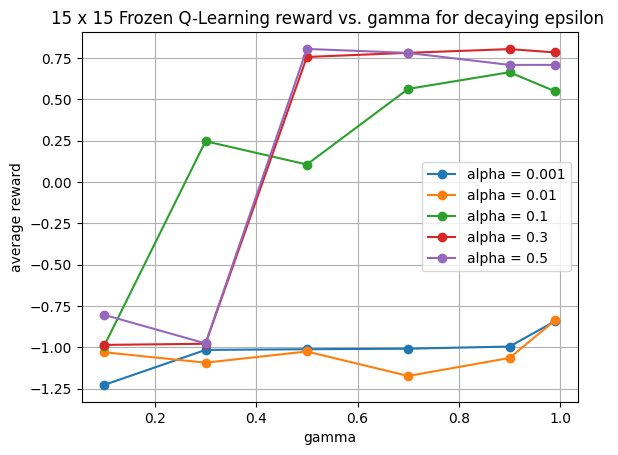

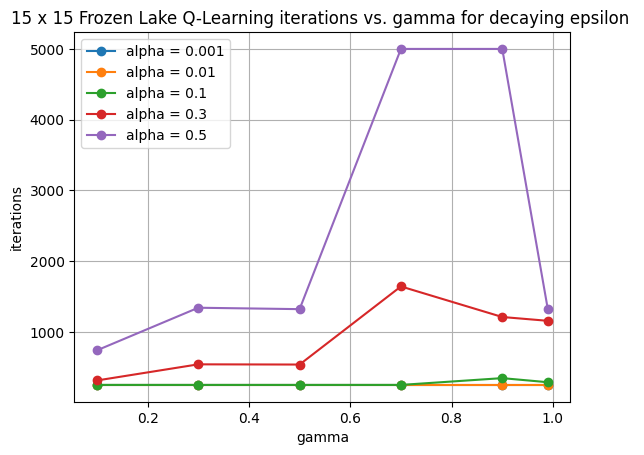

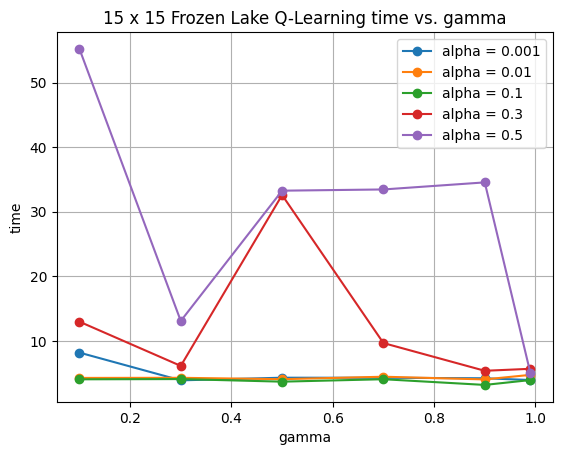

In [ ]:
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
iter_array = [251,251, 251, 314,740,251,251,251,542,1342,251,251,251,539,1322,251,251,251,1643,5000,251,251, 347,1211,5000,251,251,289,1157,1318]
reward_array = [-1.2279, -1.0301800000000005, -0.9911200000000006, -0.9859000000000006, -0.8041000000000005, -1.0161400000000005, -1.0933200000000003, 0.24607999999999974, -0.9789600000000005, -0.9769800000000005, -1.0120000000000005, -1.0256800000000004, 0.10521999999999963, 0.7557999999999999, 0.8043599999999999, -1.0087400000000004, -1.1736600000000006, 0.5625199999999999, 0.7807, 0.7802, -0.9957800000000004, -1.0647800000000005, 0.6634199999999999, 0.80324, 0.7076799999999999, -0.8420600000000003, -0.8369000000000005, 0.5478399999999999, 0.7831199999999999, 0.70778]
time_array = [8.175478219985962, 4.2555930614471436, 4.041117191314697, 12.965283155441284, 55.20762753486633, 3.8815157413482666, 4.27438759803772, 4.079013347625732, 6.118833065032959, 13.076679706573486, 4.2891974449157715, 4.060630798339844, 3.677323818206787, 32.57818031311035, 33.25377535820007, 4.281102180480957, 4.442335844039917, 4.055060386657715, 9.654526710510254, 33.4434700012207, 4.201709747314453, 4.024480104446411, 3.172276735305786, 5.361408472061157, 34.53781485557556, 3.931353807449341, 4.729487419128418, 3.9262378215789795, 5.668900012969971, 5.037363290786743]

iter_array = np.array(iter_array).reshape(6,5)
reward_array = np.array(reward_array).reshape(6,5)
time_array = np.array(time_array).reshape(6,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("15 x 15 Frozen Q-Learning reward vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()


plt.plot(gamma,  iter_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("15 x 15 Frozen Lake Q-Learning iterations vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.plot(gamma,  time_array[:,0], label = "alpha = 0.001",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "alpha = 0.01",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "alpha = 0.5",  marker = 'o')
plt.legend(loc = "best")
plt.title("15 x 15 Frozen Lake Q-Learning time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

In [ ]:
def Forest_Experiments():
	import mdptoolbox, mdptoolbox.example
	
	print('POLICY ITERATION WITH FOREST MANAGEMENT')
	P, R = mdptoolbox.example.forest(S=2000)
	value_f = [0]*10
	policy = [0]*10
	iters = [0]*10
	time_array = [0]*10
	gamma_arr = [0] * 10
	for i in range(0,10):
		pi = mdptoolbox.mdp.PolicyIteration(P, R, (i+0.5)/10)
		pi.run()
		gamma_arr[i]=(i+0.5)/10
		value_f[i] = np.mean(pi.V)
		policy[i] = pi.policy
		iters[i] = pi.iter
		time_array[i] = pi.time


	plt.plot(gamma_arr, time_array)
	plt.xlabel('Gammas')
	plt.title('Forest Management - Policy Iteration - Execution Time Analysis')
	plt.ylabel('Execution Time (s)')
	plt.grid()
	#plt.show()

	
	plt.plot(gamma_arr,value_f)
	plt.xlabel('Gammas')
	plt.ylabel('Average Rewards')
	plt.title('Forest Management - Policy Iteration - Reward Analysis')
	plt.grid()
	#plt.show()

	plt.plot(gamma_arr,iters)
	plt.xlabel('Gammas')
	plt.ylabel('Iterations to Converge')
	plt.title('Forest Management - Policy Iteration - Convergence Analysis')
	plt.grid()
	#plt.show()

	print('VALUE ITERATION WITH FOREST MANAGEMENT')
	P, R = mdptoolbox.example.forest(S=2000)
	value_f = [0]*10
	policy = [0]*10
	iters = [0]*10
	time_array = [0]*10
	gamma_arr = [0] * 10
	for i in range(0,10):
		pi = mdptoolbox.mdp.ValueIteration(P, R, (i+0.5)/10)
		pi.run()
		gamma_arr[i]=(i+0.5)/10
		value_f[i] = np.mean(pi.V)
		policy[i] = pi.policy
		iters[i] = pi.iter
		time_array[i] = pi.time


	plt.plot(gamma_arr, time_array)
	plt.xlabel('Gammas')
	plt.title('Forest Management - Value Iteration - Execution Time Analysis')
	plt.ylabel('Execution Time (s)')
	plt.grid()
	#plt.show()
	
	plt.plot(gamma_arr,value_f)
	plt.xlabel('Gammas')
	plt.ylabel('Average Rewards')
	plt.title('Forest Management - Value Iteration - Reward Analysis')
	plt.grid()
	#plt.show()

	plt.plot(gamma_arr,iters)
	plt.xlabel('Gammas')
	plt.ylabel('Iterations to Converge')
	plt.title('Forest Management - Value Iteration - Convergence Analysis')
	plt.grid()
	#plt.show()
	
	print('Q LEARNING WITH FOREST MANAGEMENT')
	P, R = mdptoolbox.example.forest(S=2000,p=0.01)
	value_f = []
	policy = []
	iters = []
	time_array = []
	Q_table = []
	rew_array = []
	for epsilon in [0.05,0.15,0.25,0.5,0.75,0.95]:
		st = time.time()
		pi = mdptoolbox.mdp.QLearning(P,R,0.95)
		end = time.time()
		pi.run(epsilon)
		rew_array.append(pi.reward_array)
		value_f.append(np.mean(pi.V))
		policy.append(pi.policy)
		time_array.append(end-st)
		Q_table.append(pi.Q)
	
	plt.plot(range(0,10000), rew_array[0],label='epsilon=0.05')
	plt.plot(range(0,10000), rew_array[1],label='epsilon=0.15')
	plt.plot(range(0,10000), rew_array[2],label='epsilon=0.25')
	plt.plot(range(0,10000), rew_array[3],label='epsilon=0.50')
	plt.plot(range(0,10000), rew_array[4],label='epsilon=0.75')
	plt.plot(range(0,10000), rew_array[5],label='epsilon=0.95')
	plt.legend()
	plt.xlabel('Iterations')
	plt.grid()
	plt.title('Forest Management - Q Learning - Decaying Epsilon')
	plt.ylabel('Average Reward')
	#plt.show()

	plt.subplot(1,6,1)
	plt.imshow(Q_table[0][:20,:])
	plt.title('Epsilon=0.05')

	plt.subplot(1,6,2)
	plt.title('Epsilon=0.15')
	plt.imshow(Q_table[1][:20,:])

	plt.subplot(1,6,3)
	plt.title('Epsilon=0.25')
	plt.imshow(Q_table[2][:20,:])

	plt.subplot(1,6,4)
	plt.title('Epsilon=0.50')
	plt.imshow(Q_table[3][:20,:])

	plt.subplot(1,6,5)
	plt.title('Epsilon=0.75')
	plt.imshow(Q_table[4][:20,:])

	plt.subplot(1,6,6)
	plt.title('Epsilon=0.95')
	plt.imshow(Q_table[5][:20,:])
	plt.colorbar()
	#plt.show()

	return

# Forest Management 

In [ ]:
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import mdptoolbox, mdptoolbox.example
import hiive.mdptoolbox.mdp,hiive.mdptoolbox.example


In [ ]:
colors = {
    0: 'g',
    1: 'y'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, row, col):
    
    policy = np.array(list(policy)).reshape(row,col)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, col+0.01), ylim = (-.01, row+0.01))

    for i in range(row):
        for j in range(col):
            y = 29 - i 
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            ax.text(x+0.5, y+0.5, labels[policy[i, j]], horizontalalignment='center', size=10, verticalalignment='center', color='w')
    ax.axis('off')

## Value Iteration 

In [ ]:
P, R = mdptoolbox.example.forest(S=900)

time_array = []
reward_array = []
iter_array = []

gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
eps = [0.1, 0.001, 0.0001, 0.00001, 0.000001] 

for g in gamma:
  for e in eps: 
      vi = hiive.mdptoolbox.mdp.ValueIteration(P, R, gamma = g, epsilon = e, max_iter = 2000)
      vi.setVerbose()
      vi.run()
      reward_array.append(np.mean(vi.V))
      iter_array.append(vi.iter)
      time_array.append(vi.time)




 Iteration   Variation
         1    4.000000
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
         2    0.180000
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
         2    0.180000
         3    0.008100
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
         2    0.180000
         3    0.008100
         4    0.000364
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
         2    0.180000
         3    0.008100
         4    0.000364
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
Iterating stopped due to maximum number of iterations condition.
 Iteration   Variation
         1    4.000000
         2    0.360000
         3    0.032400
Iterating stopped due to maximum nu

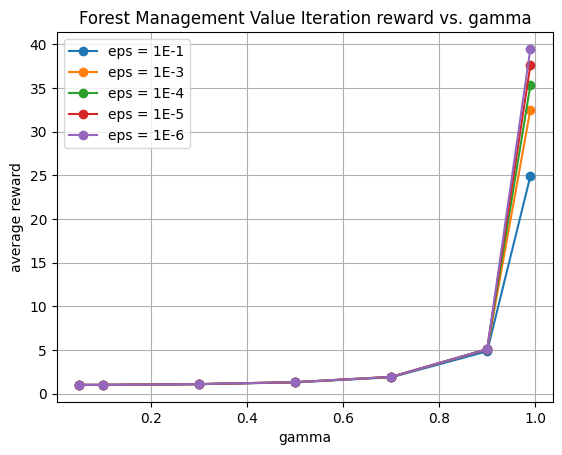

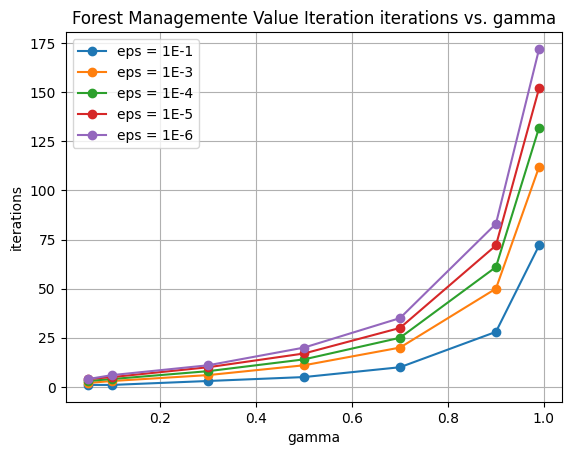

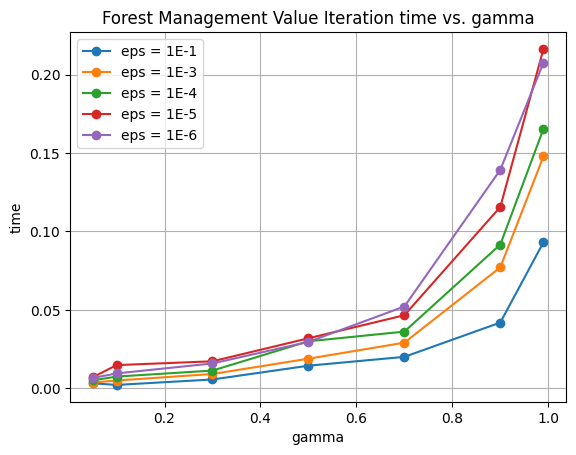

In [ ]:
iter_array = np.array(iter_array).reshape(7,5)
reward_array = np.array(reward_array).reshape(7,5)
time_array = np.array(time_array).reshape(7,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Value Iteration reward vs. gamma")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  iter_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Managemente Value Iteration iterations vs. gamma")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  time_array[:,0], label = "eps = 1E-1",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "eps = 1E-3",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "eps = 1E-4",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "eps = 1E-5",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "eps = 1E-6",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Value Iteration time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

 Iteration   Variation
         1    4.000000
         2    3.420000
         3    2.924100
         4    2.500106
         5    2.137590
         6    1.827640
         7    1.562632
         8    1.336050
         9    1.142323
        10    0.976686
        11    0.835067
        12    0.713982
        13    0.610455
        14    0.521939
        15    0.446258
        16    0.381550
        17    0.326225
        18    0.278923
        19    0.238479
        20    0.203900
        21    0.174334
        22    0.149056
        23    0.127443
        24    0.108963
        25    0.093164
        26    0.079655
        27    0.068105
        28    0.058230
        29    0.049786
        30    0.042567
        31    0.036395
        32    0.031118
        33    0.026606
        34    0.022748
        35    0.019449
        36    0.016629
        37    0.014218
        38    0.012156
        39    0.010394
        40    0.008887
        41    0.007598
        42    0.006496
        43 

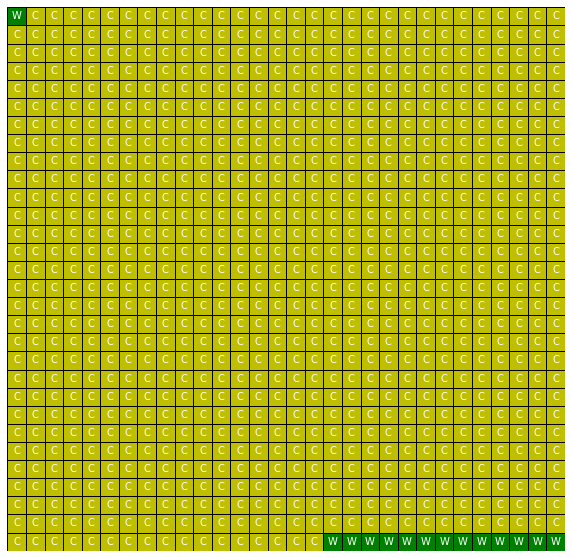

In [ ]:
P, R = mdptoolbox.example.forest(S=900)
vi = hiive.mdptoolbox.mdp.ValueIteration(P, R,  gamma = 0.95, epsilon = 0.00001, max_iter = 5000)
vi.setVerbose()
vi.run()

plot_forest(np.array(vi.policy), row = 30, col = 30)

## Policy Iteration 

In [ ]:
P, R = mdptoolbox.example.forest(S=900)

time_array = []
reward_array = []
iter_array = []

gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
eps = [0.1, 0.001, 0.0001, 0.00001, 0.000001] 

for g in gamma:
    pi = hiive.mdptoolbox.mdp.PolicyIteration(P, R, gamma = g,  max_iter = 2000)
    pi.setVerbose()
    pi.run()
    reward_array.append(np.mean(pi.V))
    iter_array.append(pi.iter)
    time_array.append(pi.time)




 Iteration   Variation
         1           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           1
         2           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           1
         2           1
         3           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           1
         2           1
         3           1
         4           1
         5           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           1
         2           1
         3           1
         4           1
         5           1
         6           1
         7           1
         8           1
         9           1
        10           0
Iterating stopped, unchanging policy found.
 Iteration   Variation
         1           1
         2           1
         3           1


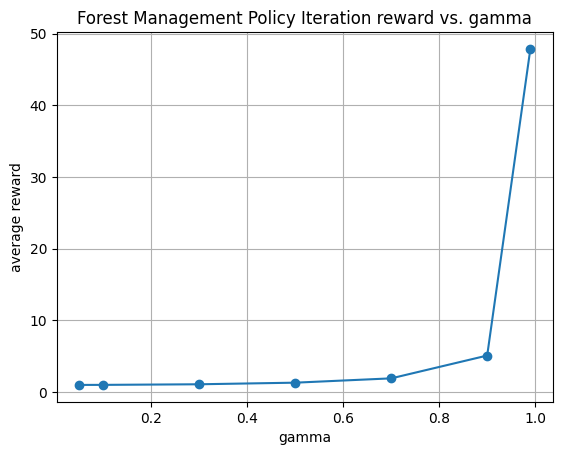

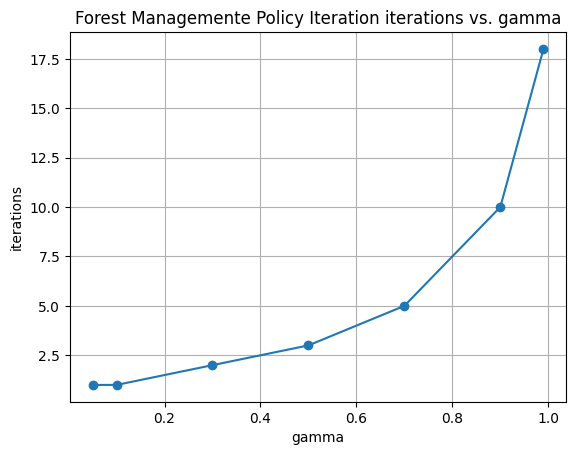

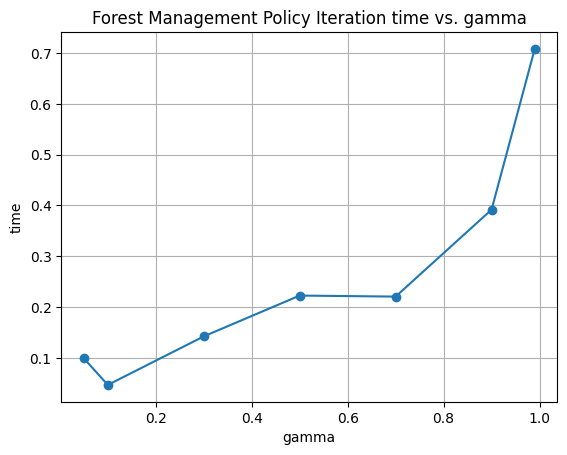

In [ ]:
plt.rcdefaults()
plt.plot(gamma,  reward_array, marker = 'o')
plt.title("Forest Management Policy Iteration reward vs. gamma")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  iter_array,  marker = 'o')
plt.title("Forest Managemente Policy Iteration iterations vs. gamma")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.rcdefaults()
plt.plot(gamma,  time_array, marker = 'o')
plt.title("Forest Management Policy Iteration time vs. gamma")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

## Q-learning 

### Alpha Decay 

In [ ]:
gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
eps =  [0.01, 0.1, 0.3, 0.5, 0.7 ]
P, R = hiive.mdptoolbox.example.forest(S=900)

In [ ]:
P, R = hiive.mdptoolbox.example.forest(S=900)
time_array = []
reward_array = []
iter_array = []

for g in gamma:
  for e in eps: 
    st = time.time()
    ql = hiive.mdptoolbox.mdp.QLearning(P, R, alpha = 0.4, gamma =g, epsilon = e, epsilon_decay = 1, n_iter=20000)
    run_stat = ql.run()
    time_array.append(time.time() - st)
    iter_array.append(run_stat[-1]['Iteration'])
    reward_array.append(np.mean(ql.V))
    


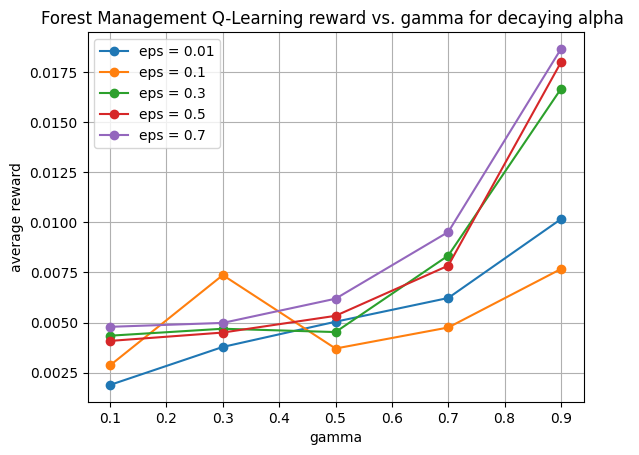

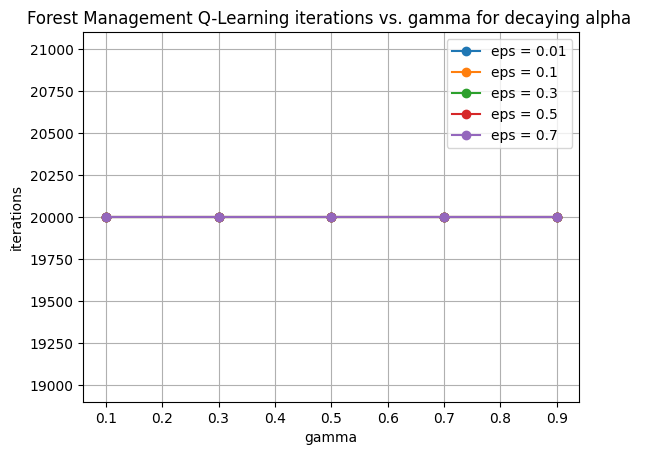

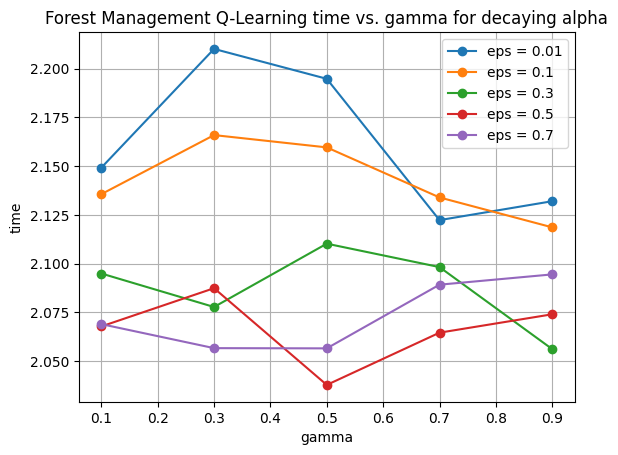

In [ ]:
iter_array = np.array(iter_array).reshape(5,5)
reward_array = np.array(reward_array).reshape(5,5)
time_array = np.array(time_array).reshape(5,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "eps = 0.5",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "eps = 0.7",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning reward vs. gamma for decaying alpha ")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()


plt.plot(gamma,  iter_array[:,0], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "eps = 0.5",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "eps = 0.7",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning iterations vs. gamma for decaying alpha ")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.plot(gamma,  time_array[:,0], label = "eps = 0.01",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "eps = 0.1",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "eps = 0.3",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "eps = 0.5",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "eps = 0.7",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning time vs. gamma for decaying alpha")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

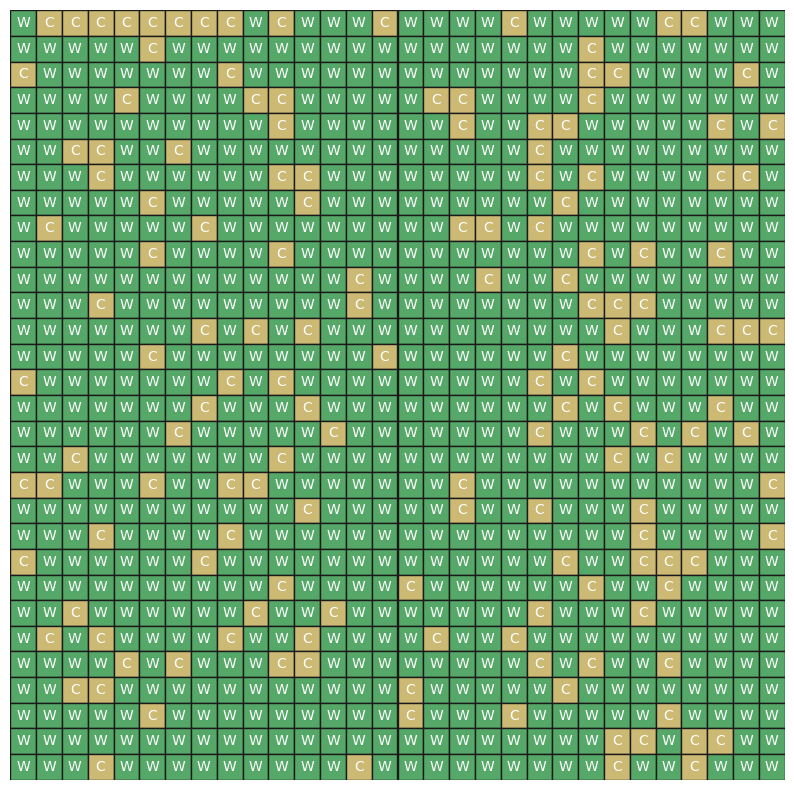

In [ ]:
ql = hiive.mdptoolbox.mdp.QLearning(P, R, alpha = 0.4, gamma =0.9, epsilon = 0.7, epsilon_decay = 1, n_iter=20000)
st = ql.run()
plot_forest(ql.policy, row = 30, col = 30)

### Epsilon Decay

In [ ]:
P, R = hiive.mdptoolbox.example.forest(S=900)
time_array = []
reward_array = []
iter_array = []

alpha = [ 0.1, 0.3, 0.5, 0.7, 0.9 ]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

for g in gamma:
  for a in alpha: 
    st = time.time()
    ql = hiive.mdptoolbox.mdp.QLearning(P, R, alpha = a, gamma =g, epsilon = 0.5, alpha_decay = 1, n_iter=20000)
    run_stat = ql.run()
    time_array.append(time.time() - st)
    iter_array.append(run_stat[-1]['Iteration'])
    reward_array.append(np.mean(ql.V))
    

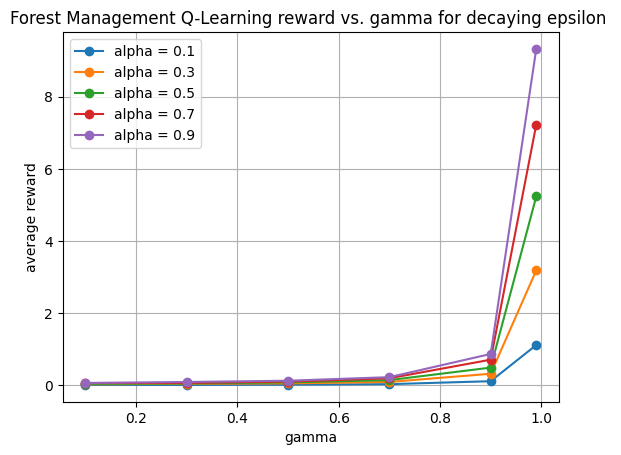

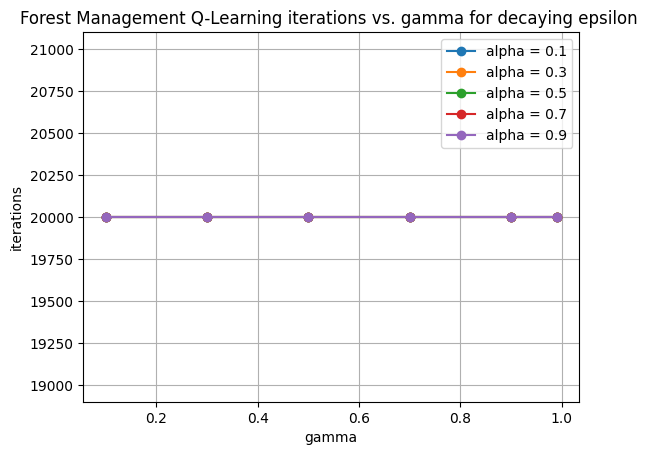

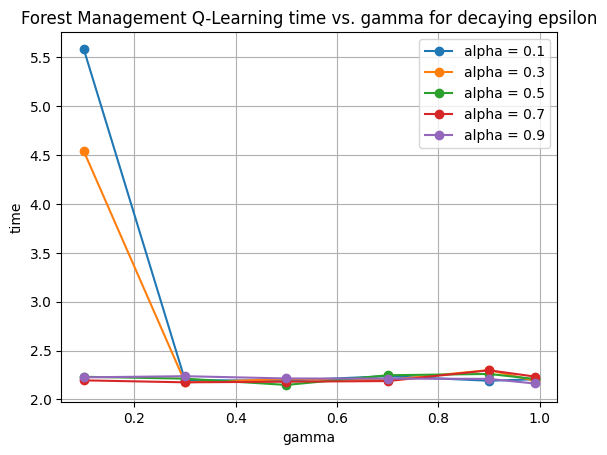

In [ ]:
iter_array = np.array(iter_array).reshape(6,5)
reward_array = np.array(reward_array).reshape(6,5)
time_array = np.array(time_array).reshape(6,5)

plt.rcdefaults()
plt.plot(gamma,  reward_array[:,0], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  reward_array[:,1], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  reward_array[:,2], label = "alpha = 0.5",  marker = 'o')
plt.plot(gamma,  reward_array[:,3], label = "alpha = 0.7",  marker = 'o')
plt.plot(gamma,  reward_array[:,4], label = "alpha = 0.9",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning reward vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("average reward")
plt.grid(True)
plt.show()


plt.plot(gamma,  iter_array[:,0], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  iter_array[:,1], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  iter_array[:,2], label = "alpha = 0.5",  marker = 'o')
plt.plot(gamma,  iter_array[:,3], label = "alpha = 0.7",  marker = 'o')
plt.plot(gamma,  iter_array[:,4], label = "alpha = 0.9",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning iterations vs. gamma for decaying epsilon ")
plt.xlabel("gamma")
plt.ylabel("iterations")
plt.grid(True)
plt.show()

plt.plot(gamma,  time_array[:,0], label = "alpha = 0.1",  marker = 'o')
plt.plot(gamma,  time_array[:,1], label = "alpha = 0.3",  marker = 'o')
plt.plot(gamma,  time_array[:,2], label = "alpha = 0.5",  marker = 'o')
plt.plot(gamma,  time_array[:,3], label = "alpha = 0.7",  marker = 'o')
plt.plot(gamma,  time_array[:,4], label = "alpha = 0.9",  marker = 'o')
plt.legend(loc = "best")
plt.title("Forest Management Q-Learning time vs. gamma for decaying epsilon")
plt.xlabel("gamma")
plt.ylabel("time")
plt.grid(True)
plt.show()

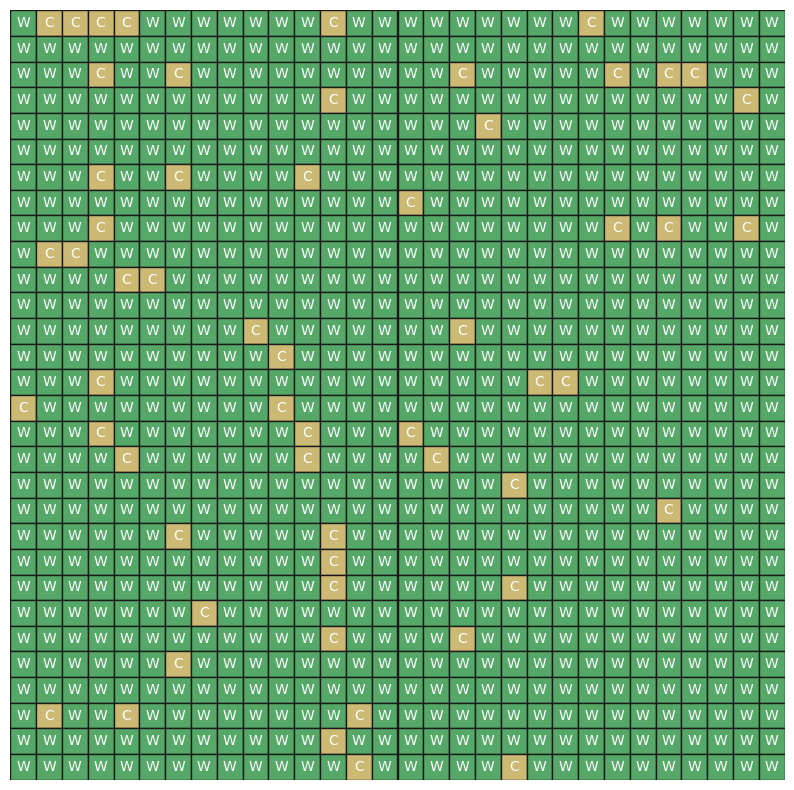

In [ ]:
ql = hiive.mdptoolbox.mdp.QLearning(P, R, alpha = 0.9, gamma =0.9, epsilon = 0.5, alpha_decay = 1, n_iter=20000)
st = ql.run()
plot_forest(ql.policy, row = 30, col = 30)

### Alpha + Epsilon Decay 

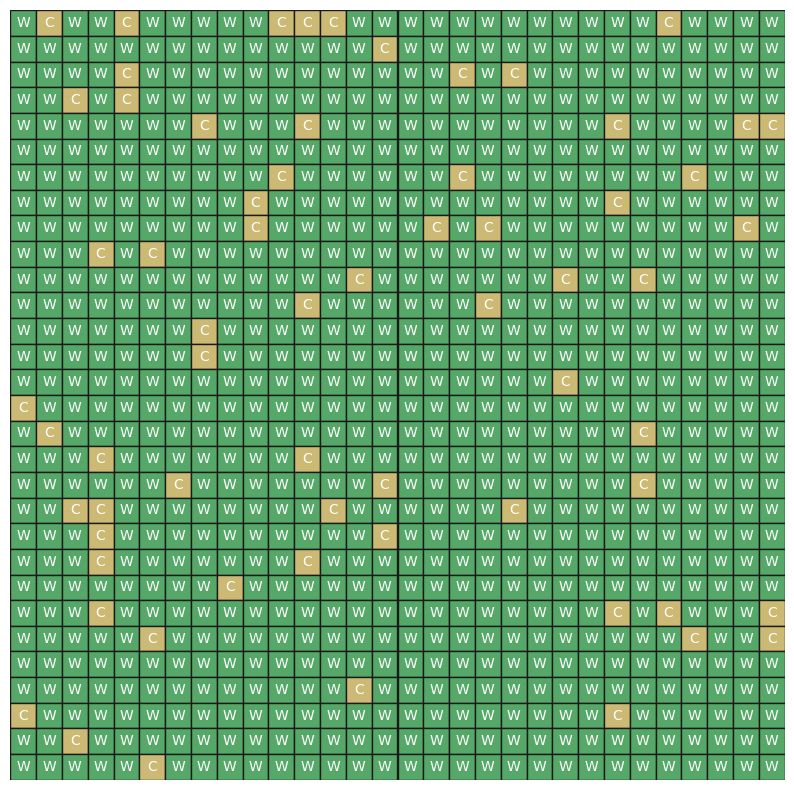

In [ ]:
ql = hiive.mdptoolbox.mdp.QLearning(P, R, alpha = 0.9, gamma =0.9, epsilon = 0.5, n_iter=20000)
st = ql.run()
plot_forest(ql.policy, row = 30, col = 30)